In [1]:
import numpy as np
import cv2
import scipy
import scipy.io
import matplotlib.pyplot as plt

import os

In [2]:
%matplotlib inline

# Global file locations
sample_video_path = "../Datasets/VIRAT_Short.mp4"
output_file_path = "outputs/"

# Notebook settings
play_video = True

## Background Subtraction

Motion detection can be captured using the idea of background and foreground subtraction. The background of an image or video frame is first identified in a static camera scenario. Once this background is identified, moving objects within the camera view that are not part of the background characteristics can be identified via background subtraction and isolated.

In this example, we adopt the use of Mixture of Gaussian(MOG) technique to model the background of a frame, over several frames. Each pixel in a frame in the background is said to be derived from a set of $K$ Gaussian mixtures with associated weights $w$, and the probability that a given pixel $x_t$ at time $t$ belonging to the background is given as

$$
p(x_t) = \sum^K_{j=1} w_j \eta(x_t;\theta_j)
$$

The reader is advised to refer to this paper[1](http://www.ee.surrey.ac.uk/CVSSP/Publications/papers/KaewTraKulPong-AVBS01.pdf) for further details.

In [3]:
# Initialize MOG Subtraction Algorithm
mog = cv2.createBackgroundSubtractorMOG2(
    history=500, 
    detectShadows=False)

# Initialize video capture instance
vid_cap = cv2.VideoCapture(sample_video_path)

Now we process each frame using the MOG background subtraction to detect motion in the video

In [4]:
# Main Loop - Processes frame and obtains the foreground mask
motion_maps = []
frames = []

while True:
    ret, frame = vid_cap.read()
    
    if frame is None:
        break
    else:
        frames.append(frame)
        
    motion_map = mog.apply(frame)
    motion_maps.append(motion_map)

We can then view the original video using the following code

In [5]:
# Play the original video
if play_video:
    for frame in frames:
        cv2.imshow("Original Video", frame)
        
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

Let's visualise the motion capture from a single frame within the MOG background subtraction algorithm

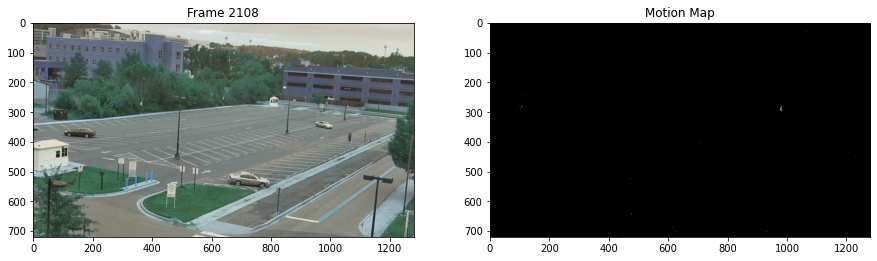

In [5]:
# Example Frame
frame_index = np.random.randint(len(frames)) # Select random frame to view motion map

plt.figure(1, figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(frames[frame_index])
plt.title("Frame {}".format(frame_index))

plt.subplot(1, 2, 2)
plt.imshow(motion_maps[frame_index], cmap=plt.cm.gray)
plt.title("Motion Map")

plt.show()

Now we save the motion maps captured using the MOG algorithm into a video and visualize them

In [6]:
# Write motion map into video
output_file_name = "motion_map.avi"

# Shape of frames
y, x = motion_maps[0].shape

video_writer = cv2.VideoWriter(
    os.path.join(output_file_path, output_file_name),
    cv2.VideoWriter_fourcc(*"XVID"), 
    30, 
    (x, y), # Axes inverted for frames 
    isColor=False)

for frame in motion_maps:
    video_writer.write(frame)
    
video_writer.release()

In [8]:
# Visualise motion map from MOG
motion_cap = cv2.VideoCapture(
    os.path.join(output_file_path, output_file_name)
)

while True:
    ret, frame = motion_cap.read()
    
    if not ret:
        break
    
    cv2.imshow("Motion Map", frame)
        
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

## Morphological Operations

You may notice that the resulting motion map can be somewhat noisy and riddle with salt and pepper noise. The MOG algorithm is sensitive and captures minute changes that are difficult to detect. To mitigate this effect, we employ the use ose morphological operations that operates on binary images.

Morphological transforms allows us to capture or eliminate various shapes occuring within an image frame. View more about morphological operations [here](https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.html)

In [20]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

motion_maps_denoised = []
for frame in motion_maps:
    closed_frame = cv2.morphologyEx(
        frame,
        cv2.MORPH_CLOSE, # Closing operation
        kernel)
    opened_frame = cv2.morphologyEx(
        closed_frame,
        cv2.MORPH_OPEN, # Opening operation
        kernel)
    motion_maps_denoised.append(opened_frame)
    
# Save denoised motion map
output_file_name = "motion_map_denoised.avi"

y, x = motion_maps_denoised[0].shape

video_writer = cv2.VideoWriter(
    os.path.join(output_file_path, output_file_name),
    cv2.VideoWriter_fourcc(*"XVID"), 
    30, 
    (x, y),
    isColor=False)

for frame in motion_maps_denoised:
    video_writer.write(frame)
    
video_writer.release()